In [7]:
from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution
import dotenv, os, json, pandas as pd, lightgbm as lgb

dotenv.load_dotenv('./.env')

P_ID = os.getenv('NUMERAI_PUBLIC_ID')
S_ID = os.getenv('NUMERAI_SECRET_ID')

In [3]:
# Initialize numerapi
napi = NumerAPI(public_id = P_ID, secret_key = S_ID)

all_datasets = napi.list_datasets()
#print(all_datasets)

# Set data version to one of the latest datasets
DATA_VERSION = "v5.0"

# download the feature metadata file
if not os.path.exists(f"{DATA_VERSION}/features.json"):
    napi.download_dataset(f"{DATA_VERSION}/features.json")

# read the metadata and display
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json")) # all the feature sets and targets (the names)
#print(json.dumps(feature_metadata, indent=2))
for metadata in feature_metadata:
  print(metadata, len(feature_metadata[metadata]))

# display the feature sets
feature_sets = feature_metadata["feature_sets"]
#print(feature_sets["small"])
for feature_set in ["small", "medium", "all"]:
  print(feature_set, len(feature_sets[feature_set]))

# Only work with the medium feature set
medium_feature_set = feature_sets["medium"]

feature_sets 17
targets 37
small 42
medium 705
all 2376


In [4]:
# Download the training data 
if not os.path.exists(f"{DATA_VERSION}/train.parquet"):  
  napi.download_dataset(f"{DATA_VERSION}/train.parquet")

# Load only the "medium" feature set 
train_feature_set = pd.read_parquet(
    f"{DATA_VERSION}/train.parquet",
    columns = ["era", "target"] + medium_feature_set
)
#print(train_feature_set.head())

# Downsample to every 4th era to reduce memory usage and speedup model training
train_feature_set_reduced = train_feature_set[train_feature_set["era"].isin(train_feature_set["era"].unique()[::4])]
#print(train_feature_set_reduced.head())

2025-03-11 10:54:54,367 INFO numerapi.utils: starting download
v5.0/train.parquet: 2.37GB [02:31, 15.6MB/s]                             


In [5]:
# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
model = lgb.LGBMRegressor(
  n_estimators=2000,
  learning_rate=0.01,
  max_depth=5,
  num_leaves=2**5-1,
  colsample_bytree=0.1
)

model.fit(
  train_feature_set_reduced[medium_feature_set],
  train_feature_set_reduced["target"]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.157000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3525
[LightGBM] [Info] Number of data points in the train set: 688184, number of used features: 705
[LightGBM] [Info] Start training from score 0.500008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, max_depth=5,
              n_estimators=2000)

In [ ]:
# Download validation data - this will take a few minutes
if not os.path.exists(f"{DATA_VERSION}/validation.parquet"):
    napi.download_dataset(f"{DATA_VERSION}/validation.parquet")

# Load the validation data and filter for data_type == "validation"
validation = pd.read_parquet(
    f"{DATA_VERSION}/validation.parquet",
    columns=["era", "data_type", "target"] + medium_feature_set
)
validation = validation[validation["data_type"] == "validation"]
validation.drop(columns=["data_type"], inplace=True)

# Downsample to every 4th era to reduce memory usage and speedup evaluation 
validation = validation[validation["era"].isin(validation["era"].unique()[::4])]

# Eras are 1 week apart, but targets look 20 days (o 4 weeks/eras) into the future,
# so we need to "embargo" the first 4 eras following our last train era to avoid "data leakage"
last_train_era = int(train_feature_set_reduced["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
validation = validation[~validation["era"].isin(eras_to_embargo)]

# Generate predictions against the out-of-sample validation features
# This will take a few minutes 🍵
validation["prediction"] = model.predict(validation[medium_feature_set])
validation[["era", "prediction", "target"]]

2025-03-11 11:10:41,433 INFO numerapi.utils: starting download
v5.0/validation.parquet: 3.34GB [03:47, 14.6MB/s]                             


,era,prediction,target
id,,,
n000c290e4364875,0579,0.491249,0.50
n002a15bc5575bbb,0579,0.505177,0.25
n00309caaa0f955e,0579,0.517842,0.75
n0039cbdcf835708,0579,0.495611,0.50
n004143458984f89,0579,0.496297,0.50
...,...,...,...
nfff25c0fac1ffd6,1151,0.500851,0.50
nfff53f275fc23e2,1151,0.496118,0.75
nfff68da2902848d,1151,0.510150,0.50


C:\Users\damie\AppData\Local\Temp\ipykernel_12612\1522143898.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_era_corr = validation.groupby("era").apply(


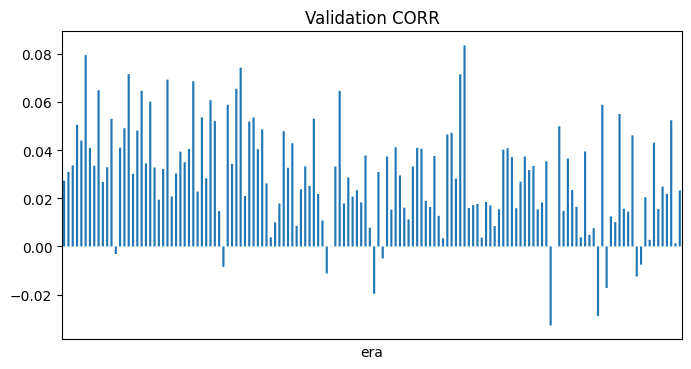

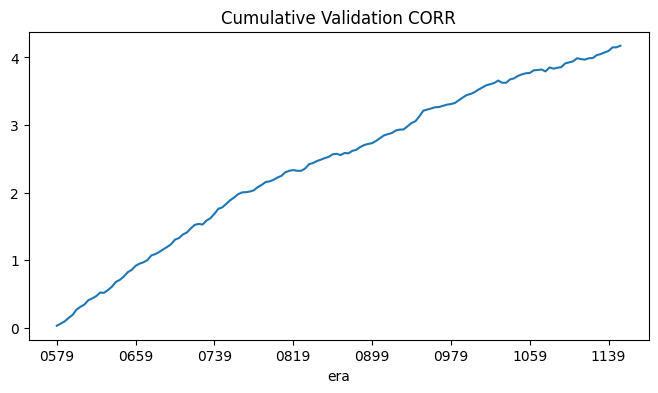

In [9]:
# Compute the per-era corr between our predictions and the target values
per_era_corr = validation.groupby("era").apply(
    lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna())
)

# Plot the per-era correlation
per_era_corr.plot(
  title="Validation CORR",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)

# Plot the cumulative per-era correlation
per_era_corr.cumsum().plot(
  title="Cumulative Validation CORR",
  kind="line",
  figsize=(8, 4),
  legend=False
)

corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std(ddof=0)
corr_sharpe = corr_mean / corr_std
corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()


In [ ]:
# Download and join in the meta_model for the validation eras (for mmc)
if not os.path.exists(f"v4.3/meta_model.parquet"):
    napi.download_dataset(f"v4.3/meta_model.parquet", round_num=842)
validation["meta_model"] = pd.read_parquet(
    f"v4.3/meta_model.parquet"
)["numerai_meta_model"]

# Compute the per-era mmc between our predictions, the meta model, and the target values
per_era_mmc = validation.dropna().groupby("era").apply(
    lambda x: correlation_contribution(x[["prediction"]], x["meta_model"], x["target"])
)

per_era_mmc.plot(
  title="Validation MMC",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)

per_era_mmc.cumsum().plot(
  title="Cumulative Validation MMC",
  kind="line",
  figsize=(8, 4),
  legend=False
)

mmc_mean = per_era_mmc.mean()
mmc_std = per_era_mmc.std(ddof=0)
mmc_sharpe = mmc_mean / mmc_std
mmc_max_drawdown = (per_era_mmc.cumsum().expanding(min_periods=1).max() - per_era_mmc.cumsum()).max()


In [ ]:
pd.DataFrame({
    "mean": [corr_mean, mmc_mean],
    "std": [corr_std, mmc_std],
    "sharpe": [corr_sharpe, mmc_sharpe],
    "max_drawdown": [corr_max_drawdown, mmc_max_drawdown]
}, index=["CORR", "MMC"]).T

In [ ]:
# Download latest live features
napi.download_dataset(f"{DATA_VERSION}/live.parquet")

# Load live features
live_features = pd.read_parquet(f"{DATA_VERSION}/live.parquet", columns=medium_feature_set)

# Generate live predictions
live_predictions = model.predict(live_features[medium_feature_set])

# Format submission
pd.Series(live_predictions, index=live_features.index).to_frame("prediction")